## Imports and Random Seed Setting

In [1]:
from collections import defaultdict
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics import BinaryAUROC

In [2]:
random_seed = 52
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

## Variables to edit when training model

In [21]:
# Change the value to specify whether to include reverse complement data or not
add_reverse_complement_data = False

## Data Setup

### Creating Splits

In [3]:
#Label data as binary
files_and_labels = {
    "expressed_B2_Mm1a.npz": 1,
    "unexpressed_B2_Mm1a.npz": 0,
    "expressed_B2_Mm1t.npz": 1,
    "unexpressed_B2_Mm1t.npz": 0,
    "expressed_B2_Mm2.npz": 1, 
    "unexpressed_B2_Mm2.npz": 0,
}

In [4]:
#Label data by families for statification
family_mapping = {
    "B2_Mm1a": 0, 
    "B2_Mm1t": 1, 
    "B2_Mm2": 2,
}
val_to_family_mapping = {
    0: "B2_Mm1a", 
    1: "B2_Mm1t", 
    2: "B2_Mm2",
}

In [5]:
#Read in data
data = []
binary_labels_list = []
family_labels_list = []

data_folder_relative_file_path = "../data/" 
for file, binary_label in files_and_labels.items():
    full_path = f"{data_folder_relative_file_path}{file}"  
    family_name = file.split("_", 1)[1].rsplit(".npz", 1)[0]
    family_label = family_mapping[family_name]

    with np.load(full_path) as npz_data:
        array = npz_data['arr_0'] 
        data.append(array) 
        binary_labels_list.append(np.full(array.shape[0], binary_label))
        family_labels_list.append(np.full(array.shape[0], family_label))

In [6]:
#Create data arrays
data = np.vstack(data)
binary_labels = np.concatenate(binary_labels_list)
family_labels = np.concatenate(family_labels_list)

In [7]:
print(np.shape(data))

(91716, 4, 300)


In [8]:
print(np.shape(binary_labels))

(91716,)


In [9]:
print(np.shape(family_labels))

(91716,)


In [11]:
#Adds reverse complement data to arrays
def add_reverse_complement(data, binary_labels, family_labels):
    reversed_data = data[:, :, ::-1]

    reverse_complement_data = reversed_data.copy()
    reverse_complement_data[:, [0, 3], :] = reversed_data[:, [3, 0], :]
    reverse_complement_data[:, [1, 2], :] = reversed_data[:, [2, 1], :]

    augmented_data = np.concatenate([data, reverse_complement_data], axis=0)

    augmented_binary_labels = np.concatenate([binary_labels, binary_labels], axis=0)
    augmented_family_labels = np.concatenate([family_labels, family_labels], axis=0)

    return augmented_data, augmented_binary_labels, augmented_family_labels


if add_reverse_complement_data:  
    data, binary_labels, family_labels = add_reverse_complement(
        data, binary_labels, family_labels
    )

print("Augmented data shape:", data.shape)
print("Augmented binary labels shape:", binary_labels.shape)
print("Augmented family labels shape:", family_labels.shape)

Augmented data shape: (91716, 4, 300)
Augmented binary labels shape: (91716,)
Augmented family labels shape: (91716,)


In [12]:
#Split data
combined_labels = list(zip(binary_labels, family_labels))

X_train, X_temp, y_train, y_temp, families_train, families_temp = train_test_split(
    data, binary_labels, family_labels, 
    test_size=0.2, stratify=combined_labels, random_state=random_seed
)

temp_combined_labels = list(zip(y_temp, families_temp))

X_val, X_test, y_val, y_test, families_val, families_test = train_test_split(
    X_temp, y_temp, families_temp, 
    test_size=0.5, stratify=temp_combined_labels, random_state=random_seed
)

print("Training set binary distribution:", np.bincount(y_train))
print("Validation set binary distribution:", np.bincount(y_val))
print("Test set binary distribution:", np.bincount(y_test))

print("Training set family distribution:", np.bincount(families_train))
print("Validation set family distribution:", np.bincount(families_val))
print("Test set family distribution:", np.bincount(families_test))

Training set binary distribution: [46746 26626]
Validation set binary distribution: [5844 3328]
Test set binary distribution: [5843 3329]
Training set family distribution: [ 9456 11574 52342]
Validation set family distribution: [1182 1447 6543]
Test set family distribution: [1182 1447 6543]


In [13]:
#Training set distribution
binary_distribution = defaultdict(lambda: {"expressed": 0, "unexpressed": 0})

for binary_label, family_label in zip(y_train, families_train):
    if binary_label == 1:
        binary_distribution[family_label]["expressed"] += 1
    else:
        binary_distribution[family_label]["unexpressed"] += 1

print("Binary distribution in the training set for each family:")
for family, counts in binary_distribution.items():
    print(f"Family {family}: Expressed = {counts['expressed']}, Unexpressed = {counts['unexpressed']}")


Binary distribution in the training set for each family:
Family 2: Expressed = 13670, Unexpressed = 38672
Family 1: Expressed = 6334, Unexpressed = 5240
Family 0: Expressed = 6622, Unexpressed = 2834


In [14]:
#Validation set distribution
binary_distribution = defaultdict(lambda: {"expressed": 0, "unexpressed": 0})

for binary_label, family_label in zip(y_val, families_val):
    if binary_label == 1:
        binary_distribution[family_label]["expressed"] += 1
    else:
        binary_distribution[family_label]["unexpressed"] += 1
        
print("Binary distribution in the validation set for each family:")
for family, counts in binary_distribution.items():
    print(f"Family {family}: Expressed = {counts['expressed']}, Unexpressed = {counts['unexpressed']}")

Binary distribution in the validation set for each family:
Family 0: Expressed = 827, Unexpressed = 355
Family 2: Expressed = 1709, Unexpressed = 4834
Family 1: Expressed = 792, Unexpressed = 655


In [15]:
#Test set distribution
binary_distribution = defaultdict(lambda: {"expressed": 0, "unexpressed": 0})

for binary_label, family_label in zip(y_test, families_test):
    if binary_label == 1:
        binary_distribution[family_label]["expressed"] += 1
    else:
        binary_distribution[family_label]["unexpressed"] += 1
print("Binary distribution in the test set for each family:")
for family, counts in binary_distribution.items():
    print(f"Family {family}: Expressed = {counts['expressed']}, Unexpressed = {counts['unexpressed']}")

Binary distribution in the test set for each family:
Family 1: Expressed = 792, Unexpressed = 655
Family 0: Expressed = 828, Unexpressed = 354
Family 2: Expressed = 1709, Unexpressed = 4834


### Loading Data

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
families_train_tensor = torch.tensor(families_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

families_val_tensor = torch.tensor(families_val, dtype=torch.long)
families_test_tensor = torch.tensor(families_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, families_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, families_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, families_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


## Defining Model 

In [17]:
#Check if GPU is recognized
torch.multiprocessing.set_sharing_strategy('file_descriptor')
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
0
NVIDIA GeForce RTX 3090 Ti
cuda:0


In [18]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv1d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        return torch.cat([x, out], 1)
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(in_channels + i * growth_rate, growth_rate))
        self.dense_layers = nn.Sequential(*layers)
    def forward(self, x):
        return self.dense_layers(x)
class SAMBAR_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=10, padding="same")
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.dense_block = DenseBlock(in_channels=128, growth_rate=32, num_layers=3)
        
        self.conv2 = nn.LazyConv1d(out_channels=128, kernel_size=10, padding="same")
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.drop2 = nn.Dropout(0.3)
        self.dense_block2 = DenseBlock(in_channels=128, growth_rate=32, num_layers=3)
        
        self.conv3 = nn.LazyConv1d(out_channels=128, kernel_size=10, padding="same")
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(128)
        self.maxpool3 = nn.MaxPool1d(kernel_size=5, stride=1)
        self.drop3 = nn.Dropout(0.3)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(64)
        self.relu6 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.LazyLinear(1)
    def forward(self, x):
        # Convolutional layer
        x = self.drop1(self.maxpool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.dense_block(x)
        x = self.drop2(self.maxpool2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.dense_block2(x)
        x = self.drop3(self.maxpool3(self.relu3(self.bn3(self.conv3(x)))))
        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Training

In [19]:
model = SAMBAR_Net().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001)
scaler = torch.cuda.amp.GradScaler()

/home/sahil/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [20]:
#Training loop
auc_metric = BinaryAUROC()

epochs = 1500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
family_metrics = {}
family_losses_history = {family: [] for family in torch.unique(families_val_tensor).tolist()}

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0
    
    for batch in train_loader:
        X_batch, y_batch, _ = batch  
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Forward pass
            y_pred = model(X_batch).squeeze()
            # Calculate loss
            loss = loss_fn(y_pred, y_batch.float()) 

        # Backward pass
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Track loss and accuracy
        running_loss += loss.detach().item()
        predictions = (torch.sigmoid(y_pred) > 0.5).float()
        correct_train_predictions += (predictions == y_batch).sum().item()
        total_train_samples += y_batch.size(0)

    train_accuracy = correct_train_predictions / total_train_samples
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation 
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    family_losses = {family: {'val_loss': 0, 'count': 0} for family in torch.unique(families_val_tensor).tolist()}

    with torch.inference_mode():
        for batch in val_loader:
            X_batch, y_batch, family_batch = batch
            X_batch, y_batch, family_batch = X_batch.to(device), y_batch.to(device), family_batch.to(device)

            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch.float())
            val_loss += loss.detach().item()

            predictions = (torch.sigmoid(y_pred) > 0.5).float()
            correct_val_predictions += (predictions == y_batch).sum().item()
            total_val_samples += y_batch.size(0)

            for family in family_losses.keys():
                mask = family_batch == family
                mask_sum = mask.sum().item()
                if mask_sum > 0:
                    family_losses[family]['val_loss'] += loss_fn(
                        y_pred[mask], y_batch[mask].float()
                    ).detach().item() * mask_sum
                    family_losses[family]['count'] += mask_sum

    val_accuracy = correct_val_predictions / total_val_samples
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch {epoch+1}, "
        f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.2%}, "
        f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2%}"
    )
    for family, metrics in family_losses.items():
        avg_loss = metrics['val_loss'] / metrics['count'] if metrics['count'] > 0 else 0
        print(f"\tFamily {val_to_family_mapping[family]}: Avg Validation Loss = {avg_loss:.4f}")
        family_losses_history[family].append(avg_loss)

    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)

# Testing
test_loss = 0.0
correct_test_predictions = 0
total_test_samples = 0
auc_metric.reset()

best_model.eval()
with torch.inference_mode():
    all_true_labels = []
    all_pred_probs = []
    all_pred_labels = []

    family_metrics = {family: {'correct': 0, 'total': 0, 'pred_labels': [], 'true_labels': []} for family in torch.unique(families_test_tensor).tolist()}

    for batch in test_loader:
        X_batch, y_batch, family_batch = batch
        X_batch, y_batch, family_batch = X_batch.to(device), y_batch.to(device), family_batch.to(device)

        y_pred = best_model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch.float())
        test_loss += loss.detach().item()

        probabilities = torch.sigmoid(y_pred)
        predictions = (probabilities > 0.5).float()

        correct_test_predictions += (predictions == y_batch).sum().item()
        total_test_samples += y_batch.size(0)
        
        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_probs.extend(probabilities.cpu().numpy())
        all_pred_labels.extend(predictions.cpu().numpy())
        
        auc_metric.update(probabilities, y_batch)

        for family in family_metrics.keys():
            mask = family_batch == family
            family_metrics[family]['correct'] += (predictions[mask] == y_batch[mask]).sum().item()
            family_metrics[family]['total'] += mask.sum().item()
            family_metrics[family]['pred_labels'].extend(torch.masked_select(predictions, mask).cpu().numpy())
            family_metrics[family]['true_labels'].extend(torch.masked_select(y_batch, mask).cpu().numpy())

test_accuracy = correct_test_predictions / total_test_samples
test_auc = auc_metric.compute().item()
prec_recall_f1_metric = precision_recall_fscore_support(all_true_labels, all_pred_labels, zero_division=1)

print(f"Final Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2%}")
print(f"Testing dataset AUC: {test_auc:.4f}")
print(f"Class 0: Precision = {prec_recall_f1_metric[0][0]:.4f}, Recall = {prec_recall_f1_metric[1][0]:.4f}, F1 Score = {prec_recall_f1_metric[2][0]:.4f}")
print(f"Class 1: Precision = {prec_recall_f1_metric[0][1]:.4f}, Recall = {prec_recall_f1_metric[1][1]:.4f}, F1 Score = {prec_recall_f1_metric[2][1]:.4f}")

print("\nFamily-wise Test Metrics:")
for family, metrics in family_metrics.items():
    family_accuracy = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    family_prec_recall_f1_metric = precision_recall_fscore_support(family_metrics[family]['true_labels'], family_metrics[family]['pred_labels'], zero_division=1)
    print(f"Family {val_to_family_mapping[family]}: Accuracy = {family_accuracy:.2%}")
    print(f"\tClass 0: Precision = {family_prec_recall_f1_metric[0][0]:.4f}, Recall = {family_prec_recall_f1_metric[1][0]:.4f}, F1 Score = {family_prec_recall_f1_metric[2][0]:.4f}")
    print(f"\tClass 1: Precision = {family_prec_recall_f1_metric[0][1]:.4f}, Recall = {family_prec_recall_f1_metric[1][1]:.4f}, F1 Score = {family_prec_recall_f1_metric[2][1]:.4f}")

torch.save(best_model.state_dict(), f"../models/SAMBAR_Net_Model.pt")

/home/sahil/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 1, Training Loss: 0.6663, Training Accuracy: 61.48%, Validation Loss: 0.6588, Validation Accuracy: 63.72%
	Family B2_Mm1a: Avg Validation Loss = 0.7325
	Family B2_Mm1t: Avg Validation Loss = 0.7007
	Family B2_Mm2: Avg Validation Loss = 0.6365
Epoch 2, Training Loss: 0.6444, Training Accuracy: 63.81%, Validation Loss: 0.6515, Validation Accuracy: 63.79%
	Family B2_Mm1a: Avg Validation Loss = 0.7218
	Family B2_Mm1t: Avg Validation Loss = 0.6917
	Family B2_Mm2: Avg Validation Loss = 0.6299
Epoch 3, Training Loss: 0.6331, Training Accuracy: 64.66%, Validation Loss: 0.6455, Validation Accuracy: 66.98%
	Family B2_Mm1a: Avg Validation Loss = 0.7035
	Family B2_Mm1t: Avg Validation Loss = 0.6790
	Family B2_Mm2: Avg Validation Loss = 0.6277
Epoch 4, Training Loss: 0.6207, Training Accuracy: 65.94%, Validation Loss: 0.6378, Validation Accuracy: 71.86%
	Family B2_Mm1a: Avg Validation Loss = 0.6886
	Family B2_Mm1t: Avg Validation Loss = 0.6679
	Family B2_Mm2: Avg Validation Loss = 0.6220
Epoc

### Loss Plots

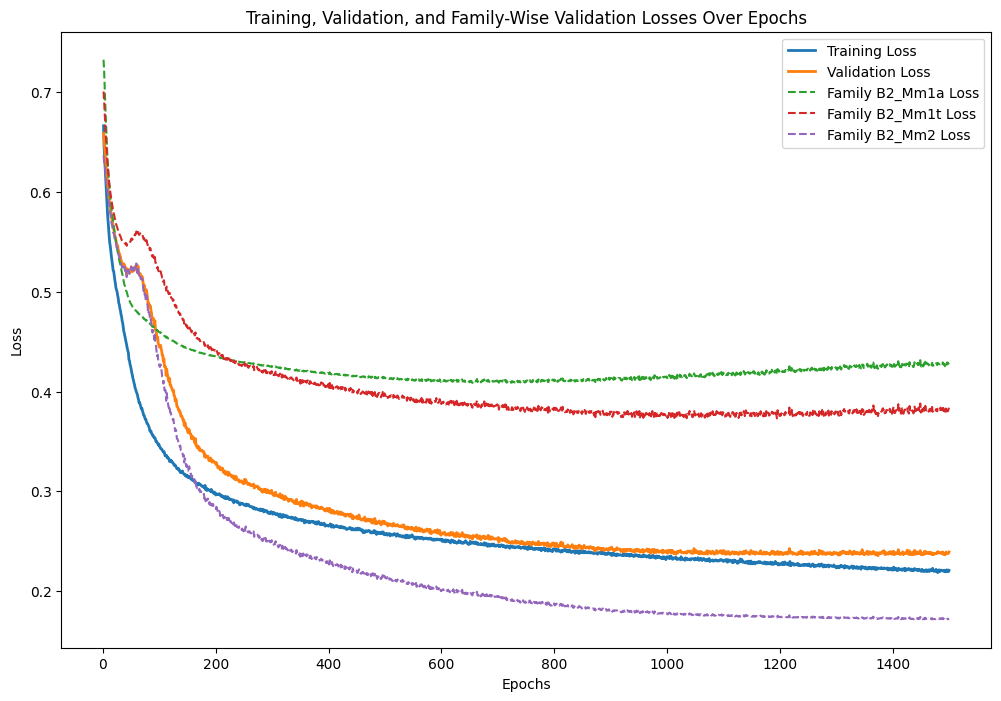

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', linewidth=2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', linewidth=2)

for family, losses in family_losses_history.items():
    plt.plot(range(1, len(losses) + 1), losses, label=f'Family {val_to_family_mapping[family]} Loss', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Family-Wise Validation Losses Over Epochs')
plt.legend()
plt.show()

### Testing Model and ROC Curves

In [22]:
best_model = SAMBAR_Net().to(device)
best_model.load_state_dict(torch.load("../models/SAMBAR_Net_Model.pt"))
loss_fn = nn.BCEWithLogitsLoss()
auc_metric = BinaryAUROC()

# ---- Final Testing ----
test_loss = 0.0
correct_test_predictions = 0
total_test_samples = 0
auc_metric.reset()

best_model.eval()
with torch.inference_mode():
    all_true_labels = []
    all_pred_probs = []
    all_pred_labels = []

    family_metrics = {family: {'correct': 0, 'total': 0, 'pred_labels': [], 'true_labels': [], 'probabilities': []} for family in torch.unique(families_test_tensor).tolist()}

    for batch in test_loader:
        X_batch, y_batch, family_batch = batch
        X_batch, y_batch, family_batch = X_batch.to(device), y_batch.to(device), family_batch.to(device)

        y_pred = best_model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch.float())
        test_loss += loss.detach().item()

        probabilities = torch.sigmoid(y_pred)
        predictions = (probabilities > 0.5).float()

        correct_test_predictions += (predictions == y_batch).sum().item()
        total_test_samples += y_batch.size(0)

        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_probs.extend(probabilities.cpu().numpy())
        all_pred_labels.extend(predictions.cpu().numpy())

        auc_metric.update(probabilities, y_batch)

        for family in family_metrics.keys():
            mask = family_batch == family
            family_metrics[family]['correct'] += (predictions[mask] == y_batch[mask]).sum().item()
            family_metrics[family]['total'] += mask.sum().item()
            family_metrics[family]['pred_labels'].extend(torch.masked_select(predictions, mask).cpu().numpy())
            family_metrics[family]['true_labels'].extend(torch.masked_select(y_batch, mask).cpu().numpy())

        for i in range(len(family_batch)):
            family = family_batch[i].item()
            family_metrics[family]['probabilities'].append(probabilities[i].item())

family_roc_curves = {}
for family_id, metrics in family_metrics.items():
    if metrics['total'] > 0:  
        fpr, tpr, thresholds = roc_curve(metrics['true_labels'], metrics['probabilities'])
        roc_auc = auc(fpr, tpr)
        family_name = val_to_family_mapping.get(family_id, f"Unknown_{family_id}")
        family_roc_curves[family_name] = {
            "fpr": fpr.tolist(),          
            "tpr": tpr.tolist(),        
            "thresholds": thresholds.tolist(),  
            "auc": roc_auc
        }

test_accuracy = correct_test_predictions / total_test_samples
test_auc = auc_metric.compute().item()
prec_recall_f1_metric = precision_recall_fscore_support(all_true_labels, all_pred_labels, zero_division=1)

print(f"Final Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2%}")
print(f"Testing dataset AUC: {test_auc:.4f}")
print(f"Class 0: Precision = {prec_recall_f1_metric[0][0]:.4f}, Recall = {prec_recall_f1_metric[1][0]:.4f}, F1 Score = {prec_recall_f1_metric[2][0]:.4f}")
print(f"Class 1: Precision = {prec_recall_f1_metric[0][1]:.4f}, Recall = {prec_recall_f1_metric[1][1]:.4f}, F1 Score = {prec_recall_f1_metric[2][1]:.4f}")

print("\nFamily-wise Test Metrics:")
for family, metrics in family_metrics.items():
    family_accuracy = metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0
    family_prec_recall_f1_metric = precision_recall_fscore_support(family_metrics[family]['true_labels'], family_metrics[family]['pred_labels'], zero_division=1)
    print(f"Family {val_to_family_mapping[family]}: Accuracy = {family_accuracy:.2%}")
    print(f"\tClass 0: Precision = {family_prec_recall_f1_metric[0][0]:.4f}, Recall = {family_prec_recall_f1_metric[1][0]:.4f}, F1 Score = {family_prec_recall_f1_metric[2][0]:.4f}")
    print(f"\tClass 1: Precision = {family_prec_recall_f1_metric[0][1]:.4f}, Recall = {family_prec_recall_f1_metric[1][1]:.4f}, F1 Score = {family_prec_recall_f1_metric[2][1]:.4f}")

# Saving data for roc curves
with open("../data/family_roc_curves.json", "w") as f:
    json.dump(family_roc_curves, f, indent=4)
    

/home/sahil/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Final Test Loss: 0.2422, Test Accuracy: 90.82%
Testing dataset AUC: 0.9591
Class 0: Precision = 0.9503, Recall = 0.9031, F1 Score = 0.9261
Class 1: Precision = 0.8436, Recall = 0.9171, F1 Score = 0.8788

Family-wise Test Metrics:
Family B2_Mm1a: Accuracy = 83.84%
	Class 0: Precision = 0.8826, Recall = 0.5311, F1 Score = 0.6631
	Class 1: Precision = 0.8287, Recall = 0.9698, F1 Score = 0.8937
Family B2_Mm1t: Accuracy = 85.56%
	Class 0: Precision = 0.8872, Recall = 0.7802, F1 Score = 0.8302
	Class 1: Precision = 0.8347, Recall = 0.9179, F1 Score = 0.8743
Family B2_Mm2: Accuracy = 93.24%
	Class 0: Precision = 0.9610, Recall = 0.9470, F1 Score = 0.9539
	Class 1: Precision = 0.8561, Recall = 0.8912, F1 Score = 0.8733


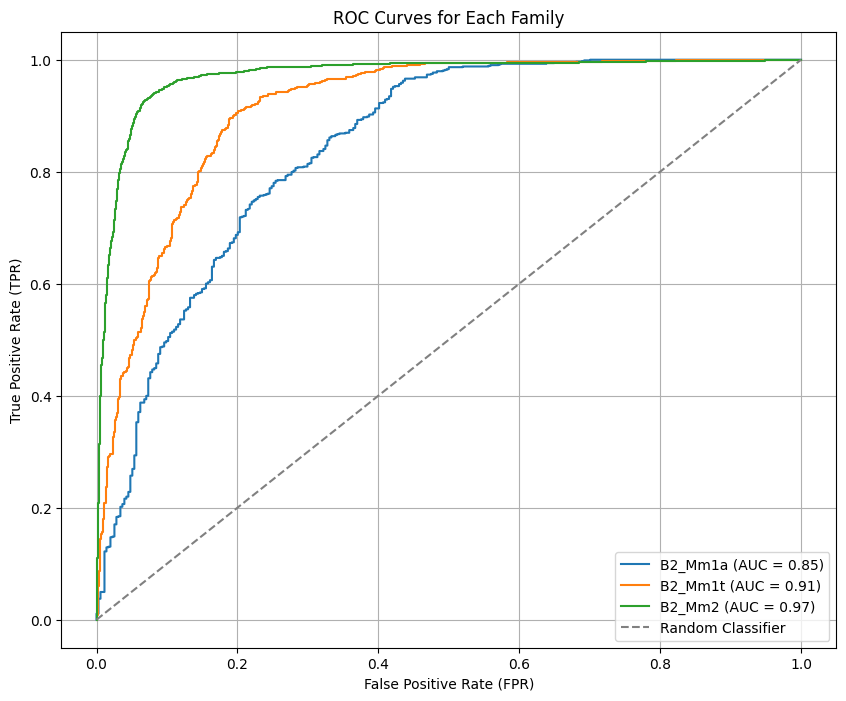

In [23]:
#Plot ROC curve
plt.figure(figsize=(10, 8))

for family_name, roc_data in family_roc_curves.items():
    fpr = roc_data["fpr"]
    tpr = roc_data["tpr"]
    auc_value = roc_data["auc"]
    
    plt.plot(fpr, tpr, label=f"{family_name} (AUC = {auc_value:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Each Family")
plt.legend(loc="lower right")
plt.grid()
plt.show()
